In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pred = pd.read_parquet('../reports/predictions.parquet')
hist = pd.read_parquet("../data/processed/m5_features.parquet")[['id','date','sales']]

In [4]:
agg = (hist.groupby('date')['sales'].sum().to_frame('y').reset_index())

agg_pred = (pred.groupby('date')['yhat'].sum().to_frame('yhat').reset_index())
view = agg.merge(agg_pred, on='date', how='outer').sort_values('date')

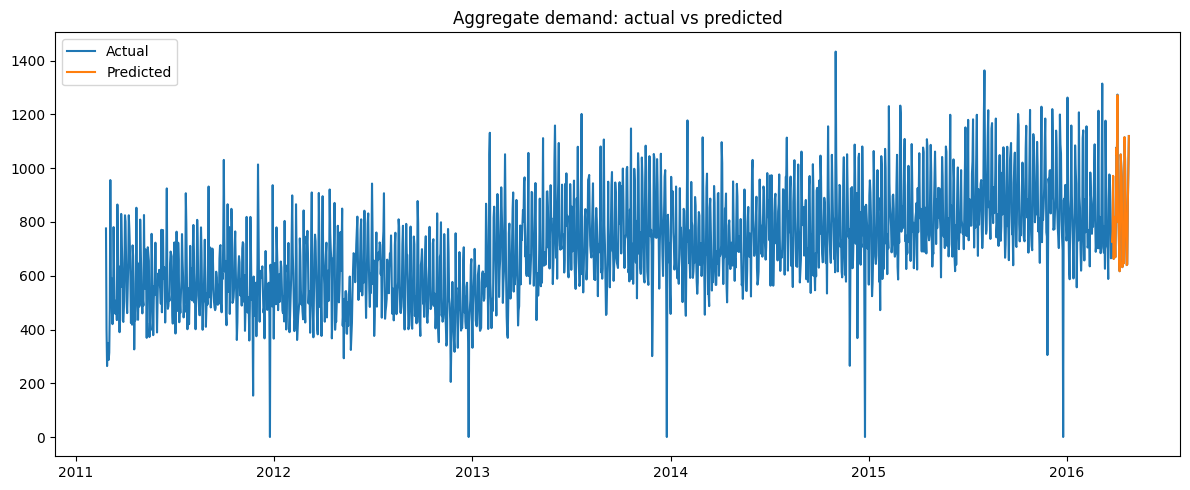

In [ ]:
#Actual vs predicted values
plt.figure(figsize=(12, 5))
plt.plot(view['date'], view['y'], label='Actual')
plt.plot(view['date'], view['yhat'], label='Predicted')
plt.title("Aggregate demand: actual vs predicted")
plt.legend()
plt.tight_layout()
plt.savefig('../reports/agg_actual_vs_predicted.png', dpi=160)

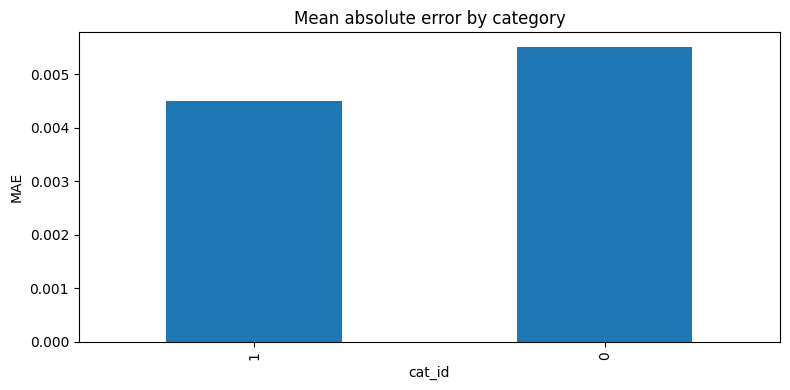

In [10]:
full = hist.merge(pred, on=['id','date'], how='left')
meta = pd.read_parquet("../data/processed/m5_features.parquet")[['id','cat_id','dept_id','store_id','state_id']].drop_duplicates()
full = full.merge(meta, on='id', how='left')

full['abs_err'] = (full['sales_x'] - full['yhat']).abs()
err_cat = full.groupby('cat_id')['abs_err'].mean().sort_values()

plt.figure(figsize=(8,4))
err_cat.plot(kind='bar')
plt.title("Mean absolute error by category")
plt.ylabel("MAE"); plt.tight_layout()
plt.savefig("../reports/mae_by_category.png", dpi=160)


In [11]:
#Calibration of intervals
if {'p10', 'p90'}.issubset(pred.columns):
    f = hist.merge(pred, on=['id','date'], how='left')
    covered = ((f['sales'] >= f['p10']) & (f['sales'] <= f['p90'])).mean()
    print("P10-P90 coverage: ", round(covered*100,2), "%")

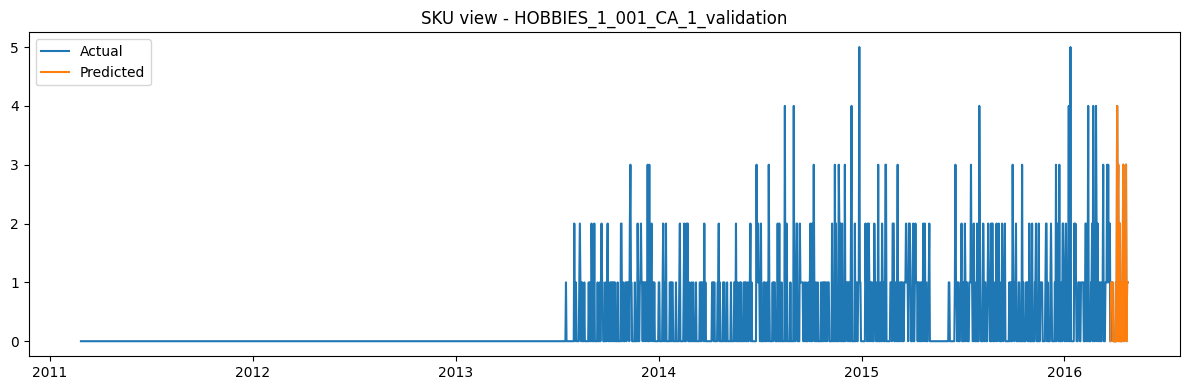

In [13]:
#SKU Spotlights
sku = full['id'].iloc[0]
v = full[full['id'] == sku].sort_values('date')

plt.figure(figsize=(12, 4))
plt.plot(v['date'], v['sales_x'], label='Actual')
plt.plot(v['date'], v['yhat'], label='Predicted')
plt.title(f"SKU view - {sku}")
plt.legend()
plt.tight_layout()
plt.savefig(f"../reports/sku_{sku}_actual_vs_pred.png", dpi=160)

C:\Users\srmpc\AppData\Local\Temp\ipykernel_29536\140852042.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bias_store = full.groupby('store_id').apply(lambda t: (t['yhat']-t['sales_x']).mean()).sort_values()


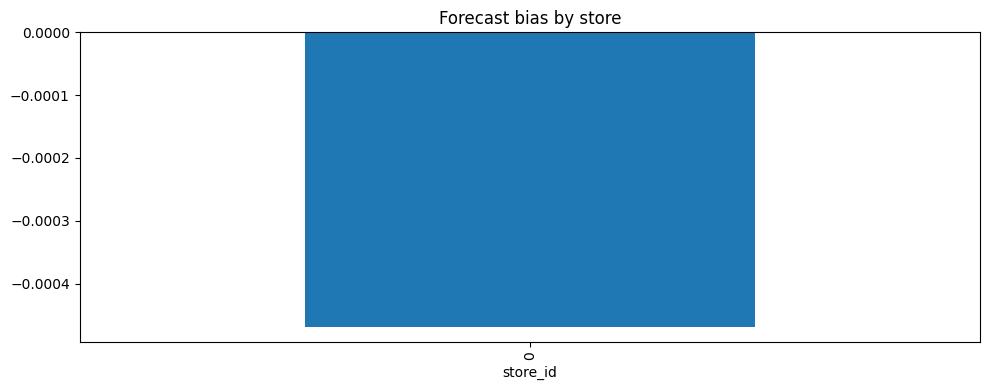

In [15]:
#Biase-Chart
bias_store = full.groupby('store_id').apply(lambda t: (t['yhat']-t['sales_x']).mean()).sort_values()
bias_store.plot(kind='bar', figsize=(10, 4), title='Forecast bias by store')
plt.tight_layout()
plt.savefig("../reports/bias_by_store.png", dpi=160)